This was created by Donna Faith Go.

# LSTM Trading
In this notebook, I will learn how to implement an LSTM model using pyTorch on a randomly generated portfolio from the S&P 500.

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# data gathering
import yfinance as yf

# LSTM neural network 
import torch
import torch.nn as nn

# comparing metrics
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    mean_absolute_percentage_error
)

# webscraping
import requests
from bs4 import BeautifulSoup
import time

# for portfolio generation
from scipy.optimize import minimize
import portfolio

# for lstm train test split
from typing import Tuple

# standardizing
from sklearn.preprocessing import StandardScaler

# ensuring pep8
%load_ext pycodestyle_magic

# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import sys
# !{sys.executable} -m pip install scikit-learn

## LSTM from Geeks for Geeks
I first learned how to implement an LSTM neural network from [the Geeks for Geeks website](https://www.geeksforgeeks.org/deep-learning/long-short-term-memory-networks-using-pytorch/).

In [3]:
# create dataframe for comparison
cols = [
    'dataset used', 'MAPE', 'MAE', 'MSE', 'R2'
]
results_df = pd.DataFrame(columns=cols)

### Geeks for Geeks Code

In [4]:
np.random.seed(0)
torch.manual_seed(0)

t = np.linspace(0, 100, 1000)
data = np.sin(t)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)\

seq_length = 10
X, y = create_sequences(data, seq_length)

trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take last time step
        return out, hn, cn

In [6]:
model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
num_epochs = 100
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    h0, c0 = h0.detach(), c0.detach()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.2866
Epoch [20/100], Loss: 0.0900
Epoch [30/100], Loss: 0.0379
Epoch [40/100], Loss: 0.0184
Epoch [50/100], Loss: 0.0027
Epoch [60/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0008
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0001


In [8]:
model.eval()
predicted, _, _ = model(trainX, h0, c0)

original = data[seq_length:]
time_steps = np.arange(seq_length, len(data))

predicted[::30] += 0.2
predicted[::70] -= 0.2

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(),
         label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.savefig('figures/LSTM Model Predictions vs. Original Data.png')
plt.close()

# getting metrics
mape_val = mean_absolute_percentage_error(original, predicted.detach().numpy())
mae_val = mean_absolute_error(original, predicted.detach().numpy())
mse_val = mean_squared_error(original, predicted.detach().numpy())
r2_val = r2_score(original, predicted.detach().numpy())

# saving to pandas dataframe
new_row = {
    'dataset used': 'sin data', 
    'MAPE': mape_val, 
    'MAE': mae_val, 
    'MSE': mse_val, 
    'R2': r2_val
}
results_df.loc[len(results_df)] = new_row

### Other Data

<div align="center">
<img src='figures/Stochastic vs Stationary data.png' />
</div>

In this section, we want to try looking at the performance of the LSTM model on stationary data. 
Stationary data is when there is no unit root present in the dataset.
Usually, data is turned stationary to make patterns in the dataset more stable and predictable for forecasting models. 
Non-stationary data with trends or seasonality usually confuses these models, leading to unreliable forecasts.
One of the common ways to turn stochastic data to stationary data is to difference it, apply log transformations, etc.

#### Stationary Data

In [9]:
# generate 1000 data points
np.random.seed(42)
num_steps = 1000
steps = np.random.choice([-1, 1], size=num_steps)
random_walk = np.cumsum(steps)
start_value = 50
random_walk_with_start = start_value + np.concatenate([[0], random_walk[:-1]])

# make it stationary
stationary_data = np.diff(random_walk_with_start)

# plot the data
fig , ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(random_walk_with_start, label='Stochastic Data')
ax[0].set_ylabel('Position')
ax[0].set_title('Stochastic Data')

ax[1].plot(stationary_data, label='Stationary Data')
ax[1].set_ylabel('Difference')
ax[1]. set_title('Stationary Data')
fig.supylabel('Position')
fig.supxlabel('Step Number')
fig.suptitle('Stochastic vs Stationary data')
plt.savefig('figures/Stochastic vs Stationary data.png')
plt.close()
# generate x and y
seq_length = 20
X, y = create_sequences(stationary_data, seq_length)
trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

In [10]:
num_epochs = 1000
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    h0, c0 = h0.detach(), c0.detach()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.9932
Epoch [200/1000], Loss: 0.9245
Epoch [300/1000], Loss: 0.2104
Epoch [400/1000], Loss: 0.0034
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0001
Epoch [900/1000], Loss: 0.0002
Epoch [1000/1000], Loss: 0.0001


In [11]:
model.eval()
predicted, _, _ = model(trainX, h0, c0)

original = stationary_data[seq_length:]
time_steps = np.arange(seq_length, len(stationary_data))

predicted[::30] += 0.2
predicted[::70] -= 0.2

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(),
         label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Stationary Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.savefig('figures/LSTM Model Predictions vs. Original Stationary Data.png')
plt.close()

# getting metrics
mape_val = mean_absolute_percentage_error(original, predicted.detach().numpy())
mae_val = mean_absolute_error(original, predicted.detach().numpy())
mse_val = mean_squared_error(original, predicted.detach().numpy())
r2_val = r2_score(original, predicted.detach().numpy())

# saving to pandas dataframe
new_row = {
    'dataset used': 'stationary data', 
    'MAPE': mape_val, 
    'MAE': mae_val, 
    'MSE': mse_val, 
    'R2': r2_val
}
results_df.loc[len(results_df)] = new_row

#### Stochastic Data

In [12]:
# generate x and y
seq_length = 20
X, y = create_sequences(random_walk_with_start, seq_length)
trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

In [13]:
num_epochs = 1000
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    h0, c0 = h0.detach(), c0.detach()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 77.3714
Epoch [200/1000], Loss: 24.6150
Epoch [300/1000], Loss: 13.7973
Epoch [400/1000], Loss: 6.0461
Epoch [500/1000], Loss: 3.5963
Epoch [600/1000], Loss: 2.2803
Epoch [700/1000], Loss: 1.7464
Epoch [800/1000], Loss: 1.5498
Epoch [900/1000], Loss: 1.4895
Epoch [1000/1000], Loss: 1.2694


In [14]:
model.eval()
predicted, _, _ = model(trainX, h0, c0)

original = random_walk_with_start[seq_length:]
time_steps = np.arange(seq_length, len(random_walk_with_start))

predicted[::30] += 0.2
predicted[::70] -= 0.2

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(),
         label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Stochastic Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.savefig('figures/LSTM Model Predictions vs. Original Stochastic Data.png')
plt.close()

# getting metrics
mape_val = mean_absolute_percentage_error(original, predicted.detach().numpy())
mae_val = mean_absolute_error(original, predicted.detach().numpy())
mse_val = mean_squared_error(original, predicted.detach().numpy())
r2_val = r2_score(original, predicted.detach().numpy())

# saving to pandas dataframe
new_row = {
    'dataset used': 'stochastic data', 
    'MAPE': mape_val, 
    'MAE': mae_val, 
    'MSE': mse_val, 
    'R2': r2_val
}
results_df.loc[len(results_df)] = new_row

### Insights

In [15]:
display(results_df)

,dataset used,MAPE,MAE,MSE,R2
0,sin data,0.130210,0.013631,0.001608,0.996812
1,stationary data,0.011643,0.011643,0.001518,0.998481
2,stochastic data,0.016232,1.003409,1.270952,0.990606


Based on the table above, it is clear that LSTM works well on either simple datasets, stochastic data, and stationary data. 
It must be noted that, although it performs better on stationary data, it is not necessarily the better choice because its performance improvement is very minimal.
Hence, adding this preprocessing step would not be good or important for the dataset. 

I want to add that I also tried doing the LSTM with different epochs, and I saw that with more epochs, the LSTM NN works better (I mean obviously! 🙄).
However, simpler datasets especially those with seasonality like the sin/cosine wave that was shown in the Geeks for Geeks example can benefit from an LSTM that has less epochs because it is less comuptationally expensive and delivers results that are already satisfactory.

## Data Gathering

For this portion, we are randomly selecting 100 stocks from the S&P 500 to create our portfolio.
The size of 100 was chosen because we want a diverse portfolio.
Furthermore, we also scraped the GSPC stock price because it is the ticker symbol for the S&P 500.
Usually, this is used as a benchmark for the overall US stock market to determine how well a portfolio or a trading strategy is doing.

In [16]:
# getting the stock tickers
headers = {
    'User-Agent': (
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
        '(KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    )
}

response = requests.get(
    "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",
    headers=headers
)
response.raise_for_status()
tables = pd.read_html(response.text)

if len(tables) > 0:
    stocks_df = tables[0]

# randomly selecting 30 stocks
random_stocks = stocks_df['Symbol'].sample(n=100, random_state=42)

In [17]:
# getting closing prices for the 30 stocks with batching
start_date = '2022-01-01'
end_date = '2025-01-01'

def download_stocks_in_batches(tickers, batch_size=5, delay=1):
    """
    Download stock data in batches to avoid rate limiting
    """
    all_data = {}
    
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"Downloading batch {i//batch_size + 1}: {batch}")
        
        try:
            # Download the batch
            batch_data = yf.download(
                batch,
                start=start_date,
                end=end_date,
                progress=False
            )
            
            # Extract closing prices for this batch
            if not batch_data.empty and 'Close' in batch_data.columns:
                closes = batch_data['Close']
                if isinstance(closes, pd.Series):
                    all_data[batch[0]] = closes
                else:
                    for ticker in closes.columns:
                        all_data[ticker] = closes[ticker]
                print(f"Successfully downloaded {len(batch)} stocks")
            else:
                print(f"No data returned for batch: {batch}")
            
        except Exception as e:
            print(f"Error downloading batch {batch}: {e}")
        
        # Add delay to avoid rate limiting
        if i + batch_size < len(tickers):
            print(f"Waiting {delay} seconds before next batch...")
            time.sleep(delay)
    
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return pd.DataFrame()

# # Download in batches of 5 stocks with 1-second delay
# closing_df = download_stocks_in_batches(
#     random_stocks.tolist(), 
#     batch_size=5, 
#     delay=15
# )

# if not closing_df.empty:
#     closing_df.to_pickle('data/closing prices.pkl')

# closing_df.head(5)

# # Download in batches of 5 stocks with 1-second delay
# closing_df = download_stocks_in_batches(
#     ['^GSPC'], 
#     batch_size=5, 
#     delay=15
# )

# if not closing_df.empty:
#     closing_df.to_pickle('data/gspc prices.pkl')

# closing_df.head(5)

Note: The code above takes around 5 minutes to run. 

In [18]:
# opening pkl file
filename = r'data/closing prices.pkl'
with open(filename, 'rb') as f: 
    closing_df = pickle.load(f)
    closing_df.index = pd.to_datetime(closing_df.index)

# getting s&p 500 data
filename = r'data/gspc prices.pkl'
with open(filename, 'rb') as f: 
    gspc_df = pickle.load(f)
    gspc_df.index = pd.to_datetime(gspc_df.index)
gspc_df.rename(columns={'^GSPC': 'GSPC'}, inplace=True)

## Portfolio Generation

Usually, assigning weights yearly for the firms in your portfolio would make more sense.
Patterns in firms change as they have to account for new external factors every year such as shifting market conditions, competition from other firms, and more. 
By changing the weights annually, we are able to incorporate recent financial performance and adjust for any structural changes in the companies.

To make things simple, I will use the Markowitz Portfolio Optimization model to assign weights to the different stocks.
Here, the best portfolios were chosen based on their Sharpe ratio.
For context, the Sharpe Ratio measures an investment's risk-adjusted return. 
It indicates how much extra return you get for the extra volatility (risk) you take on compared to a risk-free asset.

In [19]:
cols = [
    'year', 'expected return', 'volatility', 'sharpe ratio'
]
results_df = pd.DataFrame(columns=cols)

# # generate portfolios
# years = ['2022', '2023', '2024']
# for year in years:
#     p = portfolio.generate_portfolio(
#         closing_df.loc[year],
#         year
#     )
#     weights, results, stocks = p.get_portfolio()
#     ef_portfolio = pd.Series(weights, index=stocks)
#     ef_portfolio.to_pickle(
#         f'portfolios/{year} ef portfolio.pkl'
#     )
#     results_df.loc[len(results_df)] = results

## EDA I

In [20]:
# get historical data
historical_data = closing_df.copy()

# check nulls
if any(historical_data.isnull().sum() > 1):
    print('There are still some nulls for historical data.')
else:
    print('There are no more nulls for historical data.')

There are still some nulls for historical data.


Since there are some columns with nulls, we are going to have to drop them. 

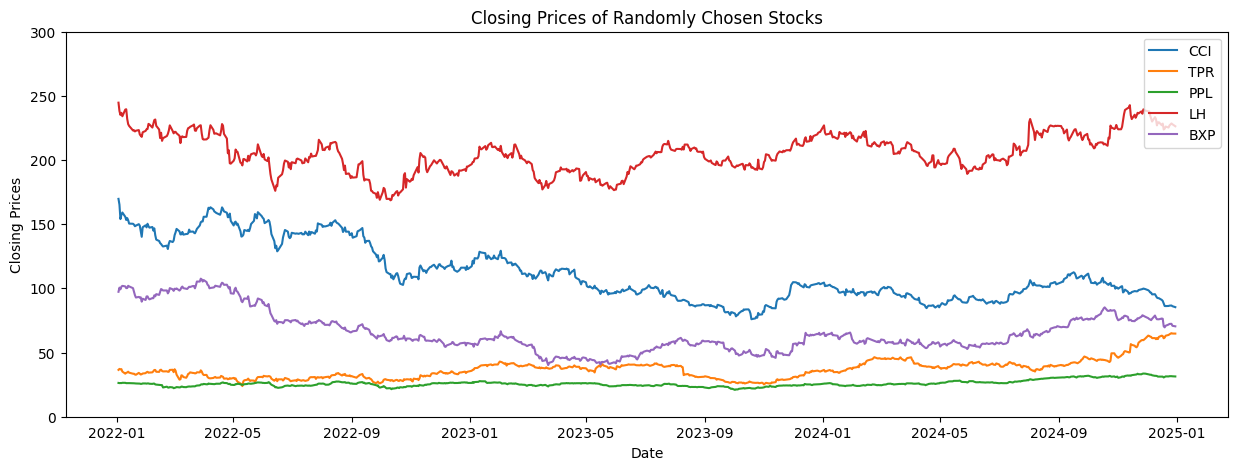

In [21]:
# randomly selecting stocks
np.random.seed(42)
random_stocks = np.random.choice(historical_data.columns, 5)

# plotting the closing prices of random stocks
plt.figure(figsize=(15, 5))
for stock in random_stocks:
    plt.plot(historical_data[stock], label=stock)
plt.legend(loc='upper right')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.ylim(0, 300)
plt.title('Closing Prices of Randomly Chosen Stocks')
plt.show()

Based on the figure above, we can see that there are significant differences in the closing stock prices. 
We'll have to turn the data into log returns or standardize the data in order to make meaningful comparisons.
This transformation will also make the time series more stationary which makes it easier for machine learning models to forecast price.

## Feature Engineering

In [22]:
# dropping stocks with null columns
historical_data = historical_data.dropna(axis=1, how='any')

# get log returns
log_returns = historical_data.pct_change().dropna(how='all')
print(f'There are a total of {len(log_returns.columns)} remaining after feature engineering.')

# standardize data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(historical_data.values)
standardized_df = pd.DataFrame(standardized_data, columns=historical_data.columns)

# check nulls for log returns
if any(log_returns.isnull().sum() > 1):
    print('There are still some nulls for log returns.')
else:
    print('There are no more nulls for log returns.')

# check nulls for standardized closing prices
if any(standardized_df.isnull().sum() > 1):
    print('There are still some nulls for standardized data.')
else:
    print('There are no more nulls for standardized data.')

There are a total of 96 remaining after feature engineering.
There are no more nulls for log returns.
There are no more nulls for standardized data.


When training the model, we want to make sure that it is not handling any null data because this might affect how well it can forecast.

## EDA II

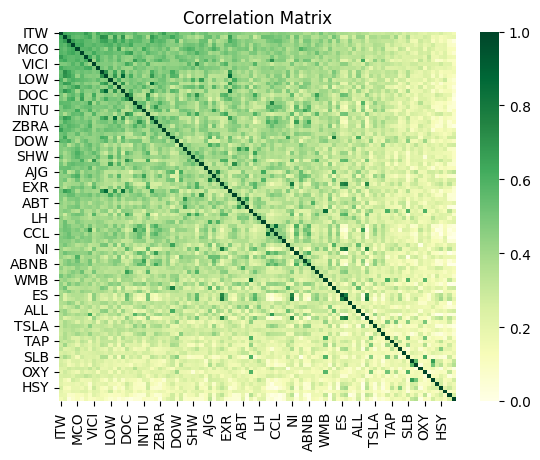

In [23]:
# get correlations
correl_matrix = log_returns.corr()
order = correl_matrix.mean().sort_values(ascending=False).index
correl_matrix_sorted = correl_matrix.loc[order, order]

# plotting
plt.figure()
sns.heatmap(
    correl_matrix_sorted, cmap='YlGn', fmt=".2f", vmin=0, vmax=1
)
plt.title('Correlation Matrix')
plt.show()

The heatmap of the correlation matrix shows that a lot of the stocks, based on their log returns, are closer to weak to negligible correlation.
This entails that we have a diverse portfolio which is ideal for mitigating unsystematic risk within our trading strategy.

## LSTM NN Implementation

First, we have to define the functions to be used by the machine learning mode. 
The functions for the splitting the time series with a lookback window is from Professor Ethan Robert A. Casin's lectures for our Machine Learning II course.

In [24]:
# train test split with lookback
def train_test_split(data: pd.Series, lookback: int = 12, test_size: int = 12) -> Tuple[pd.Series, pd.Series]:
    """Create a train-test split on your pd.Series data.

    Parameters:
    -----------
    data (pd.Series): The univariate time series provided
    lookback (int): The lookback periods to consider
    test_size (int): The length of the test set

    Returns:
    --------
    Tuple (pd.Series): The (train, test) pandas series generated
    """
    
    split = data.shape[0] - test_size
    return (
        data.iloc[:split],
        data.iloc[split - lookback: ]
    )

# split data into features and target
def create_xy(series: pd.Series, lookback: int = 12, horizon: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    """Create the X and y arrays from a pd.Series object. The `lookback`
    determines the number of features we would include in X. While the
    `horizon` paramter informs us how many points we'll need to forecast.

    Paramters:
    ----------
    series (pd.Series): the (n, 1) time series to be sliced into X and Y
    lookback (int): the lookback window to consider (default=12)
    horizon (int): the number of points to forecast for each row in X (default=1)

    Returns:
    -------
    (X, y) (Tuple): a tuple of ndarrays
    """
    x = []
    y = []
    
    series_size = series.shape[0]
    for i in range(series_size):
        
        # break loop if series is less than the required time horizon
        if series.iloc[(i + lookback): (i + lookback + horizon)].shape[0] < horizon:
            break
        x.append(
            series.iloc[i: (i + lookback)]
        )
        y.append(
            series.iloc[(i + lookback): (i + lookback + horizon)]
        )
    x = np.dstack(x)
    y = np.dstack(y)

    # Reshape x to (samples, features, lookback)
    x = np.swapaxes(x, 0, 2)
    # Then flatten (samples, features * lookback)
    x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])

    # Reshape y tp (samples, horizon)
    y = np.swapaxes(y, 0, 2)
    y = y[:, :, 0]
    
    return x, np.array(y).flatten()

# evaluating model performance
def evaluate_model(model, x, y):
    outputs = model(x)
    y_pred = outputs.detach().numpy()
    y_true = y.detach().numpy()
    
    mape_val = mean_absolute_percentage_error(y_true,y_pred)
    mae_val = mean_absolute_error(y_true, y_pred)
    mse_val = mean_squared_error(y_true,y_pred)
    r2_val = r2_score(y_true, y_pred)
    
    return mape_val, mae_val, mse_val, r2_val

### Model Architecture

The LSTM model follows the usual architecture, but for this implementation, we will only train one model for all 100 stocks in our portfolio.

**Insert a more detailed explanation of the model architecture.**

In [25]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size = input_size, 
            hidden_size = hidden_size, 
            num_layers = num_layers, 
            batch_first = True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze(-1)

# loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # weight_decay=0.1

💡 Something new I learned today:
- The `weight_decay` parameter in the Adam optimizer is something that is different from batch normalization. Here, it penalizes large weights in the neural network to ensure that there is no overfitting.

### Model Training

Note: The code below takes more than 5 hours to run on a CPU. 
I highly recommend that you ask someone with a GPU to run this code or run it overnight when you don't have to use your laptop.

In [26]:
# check if you have a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# defining parameters for training
train_ratio = 0.8
epochs = 750
lookback = 252 # last year of trading

# create dataframe for model performance
cols = [
    'MAPE', 'MAE', 'MSE', 'R2'
]
idx = log_returns.columns.to_list()
results_df = pd.DataFrame(columns=cols, index=idx)

# training and storing predictions
all_predictions = {}
for firm in standardized_df.columns:
    # features and target
    X, y = create_xy(standardized_df[firm], lookback=lookback, horizon=1) # 20 days because 20 trading days

    # train and validation sets
    split_index = int(len(X) * train_ratio)
    x_train, x_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    # datasets into tensors
    x_train_tensors = torch.from_numpy(x_train).float()
    x_val_tensors = torch.from_numpy(x_val).float()
    y_train_tensors = torch.from_numpy(y_train).float()
    y_val_tensors = torch.from_numpy(y_val).float()

    # missing input_dim dimension
    x_train_tensors = x_train_tensors.unsqueeze(-1)
    x_val_tensors = x_val_tensors.unsqueeze(-1)

    # model features
    input_size = 1
    hidden_size = 128 # half a year
    num_layers = 2
    output_size = 1
    
    # instantiate model
    model = LSTMModel(
        input_size, hidden_size, num_layers, output_size
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # weight_decay=0.1
    x_train_tensors = x_train_tensors.to(device)
    y_train_tensors = y_train_tensors.to(device)
    x_val_tensors = x_val_tensors.to(device)
    y_val_tensors = y_val_tensors.to(device)

    # train model
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train_tensors)
        loss = criterion(outputs, y_train_tensors)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(
                f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}'
            )

    # evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val_tensors)
        val_loss = criterion(val_outputs, y_val_tensors)
        print(
            f'Validation Loss: {val_loss.item(): .2f}'
        )

    # get daily predictions
    daily_preds = []
    val_series = standardized_df[firm][-len(x_val_tensors)-lookback:] 
    for i in range(len(x_val_tensors)):
        x_seq = val_series.iloc[i:i+lookback].values
        x_tensor = torch.tensor(x_seq).float().unsqueeze(0).unsqueeze(-1)
        x_tensor = x_tensor.to(next(model.parameters()).device)
        pred = model(x_tensor)
        daily_preds.append(pred.item())
        
    all_predictions[firm] = pd.Series(
        daily_preds,
        index=standardized_df.index[-len(x_val_tensors):]
    )

    # evaluate model performance
    mape_val, mae_val, mse_val, r2_val = evaluate_model(model, x_val_tensors, y_val_tensors)
    results_df.loc[firm] = [mape_val, mae_val, mse_val, r2_val]

    # save model
    torch.save(model.state_dict(), f'models/{firm} model.pth')
    print(f'Done for {firm}')

Epoch [1/750], Loss: 0.5125
Epoch [101/750], Loss: 0.0111
Epoch [201/750], Loss: 0.0073
Epoch [301/750], Loss: 0.0038
Epoch [401/750], Loss: 0.0048


KeyboardInterrupt: 

## Model Performance

In [ ]:
results_df.sort_values(by='R2')

After doing multiple trial and error runs on my LSTM neural network I learned the following:
1. Do not try to predict on log returns; it is better to try to predict on standardized data.
2. Make sure your lookback window matches your hidden layer.
3. You should increase your epochs in order to make the model fit the data better, but if you increase it by too much, then it could increase the loss in your model.

## Predictions

In [ ]:
for firm in standardized_df.columns:
    # get true and predicted values
    y_true = standardized_df[firm][-len(all_predictions[firm]):]
    y_pred = all_predictions[firm]

    # plot the values
    plt.figure(figsize=(15, 3))
    plt.plot(y_true, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(
        f'True vs Predicted Values for {firm}'
    )
    plt.legend()
    plt.show()

## Conclusion